In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Load Data

In [3]:
import io
df = pd.read_csv("../input/data-fake-or-not/data.csv")

In [4]:
df

,Unnamed: 0,title,text,label,Government News,Middle-east,News,US_News,left-news,politics,politicsNews,worldnews
0,0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,1,0,0,0,0,0,0,1,0
1,1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,1,0,0,0,0,0,0,1,0
2,2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,1,0,0,0,0,0,0,1,0
3,3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,1,0,0,0,0,0,0,1,0
4,4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,1,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
44893,23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,0,0,1,0,0,0,0,0,0
44894,23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,0,0,1,0,0,0,0,0,0
44895,23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,0,0,1,0,0,0,0,0,0
44896,23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,0,0,1,0,0,0,0,0,0


In [5]:
df.drop(columns=['Unnamed: 0'], inplace=True)

In [6]:
df.head(3)

,title,text,label,Government News,Middle-east,News,US_News,left-news,politics,politicsNews,worldnews
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,1,0,0,0,0,0,0,1,0
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,1,0,0,0,0,0,0,1,0
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,1,0,0,0,0,0,0,1,0


In [7]:
train = df[:30000]
test = df[30000:]

train_sentences = train['title'].tolist()
test_sentences = test['title'].tolist()

## **Tokenize Dataset**

In [8]:
vocab_size = 5000
embedding_dim = 16
max_length = 500
trunc_type = 'post'
padding_type = 'post'
oov_tok = '<OOV>'

In [16]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(train_sentences)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(train_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type)

testing_sequences = tokenizer.texts_to_sequences(test_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

## **Building the Model**

In [17]:
# detect and init the TPU
tpu = tf.distribute.cluster_resolver.TPUClusterResolver.connect()

# instantiate a distribution strategy
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

# instantiating the model in the strategy scope creates the model on the TPU
with tpu_strategy.scope():
    model = tf.keras.models.Sequential()

    model.add(tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(300, dropout=0.3, recurrent_dropout=0.3)
    ))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    model.summary() # define your model normally
    model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 16)           80000     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 600)               760800    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 601       
Total params: 841,401
Trainable params: 841,401
Non-trainable params: 0
_________________________________________________________________


In [18]:
cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

In [19]:
data_model = model.fit(training_padded, train['label'], epochs=50, validation_data=(testing_padded, test['label']), callbacks=[cb])

Epoch 1/50
938/938 [==============================] - 108s 107ms/step - loss: 0.2740 - accuracy: 0.8771 - val_loss: 0.3178 - val_accuracy: 0.8760
Epoch 2/50
938/938 [==============================] - 96s 102ms/step - loss: 0.0538 - accuracy: 0.9801 - val_loss: 0.2508 - val_accuracy: 0.9146
Epoch 3/50
938/938 [==============================] - 96s 102ms/step - loss: 0.0364 - accuracy: 0.9885 - val_loss: 0.3512 - val_accuracy: 0.8819
Epoch 4/50
938/938 [==============================] - 96s 102ms/step - loss: 0.0243 - accuracy: 0.9922 - val_loss: 0.4331 - val_accuracy: 0.8837


In [20]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Loss')

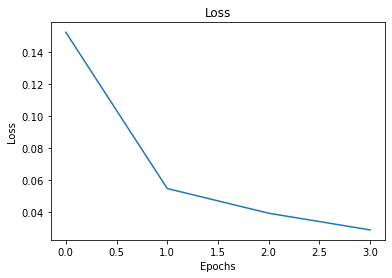

In [21]:
plt.plot(data_model.history['loss'])
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

Text(0, 0.5, 'Val Loss')

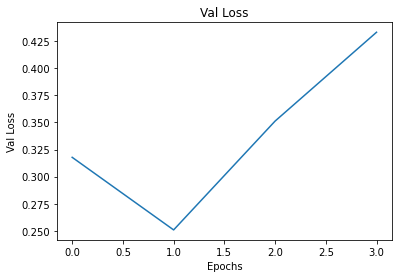

In [22]:
plt.plot(data_model.history['val_loss'])
plt.title('Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Val Loss')

Text(0, 0.5, 'Acuracy')

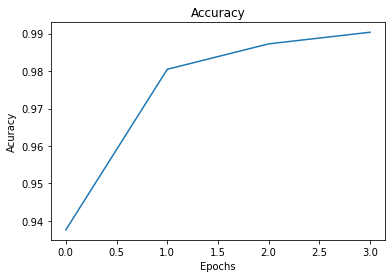

In [23]:
plt.plot(data_model.history['accuracy'])
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Acuracy')

Text(0, 0.5, 'Val Accuracy')

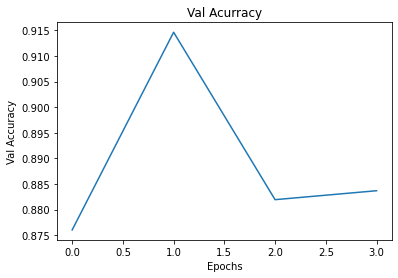

In [24]:
plt.plot(data_model.history['val_accuracy'])
plt.title('Val Acurracy')
plt.xlabel('Epochs')
plt.ylabel('Val Accuracy')

In [25]:
model.save("./model.h5")